In [1]:
import numpy as np
import os
import cv2
from itertools import combinations
import matplotlib.pylab as plt
from scipy.spatial.distance import euclidean
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def show_gray(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap="gray")

In [2]:
def separate_plots(img): # возвращает список графиков
    colors = cv2.split(img)
    color_pairs = combinations(colors, 2)
    plots = [x[0]|x[1] for x in color_pairs]
    plots = [cv2.threshold(x, thresh=90, maxval=255, type=cv2.THRESH_BINARY_INV)[1] for x in plots]
    return plots

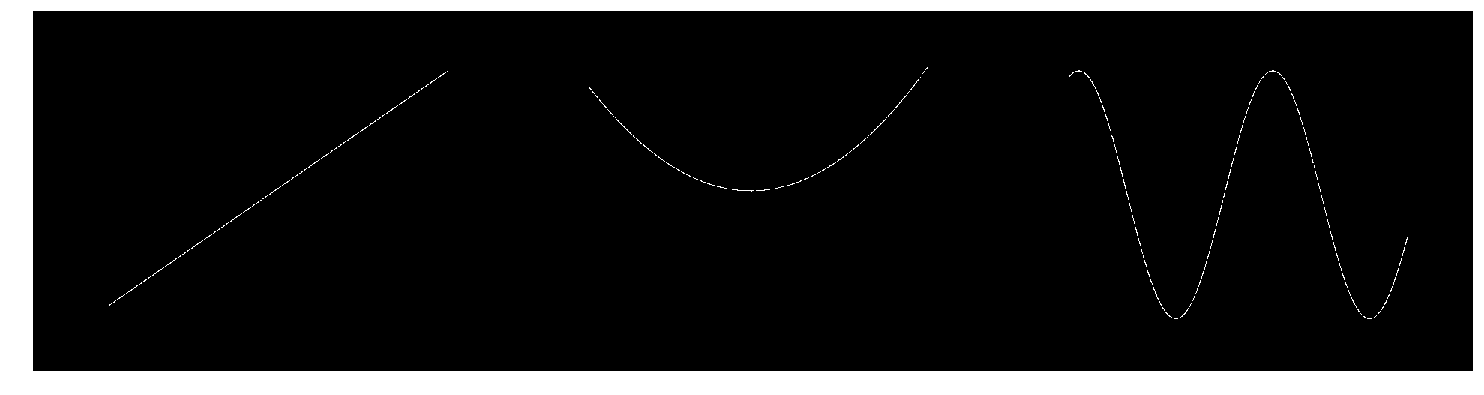

In [3]:
# пример работы
img = cv2.imread("plots/20/10.png")
plots = separate_plots(img)
plt.figure(figsize=(20, 20))
show_gray(np.hstack(plots))

(249, 328)


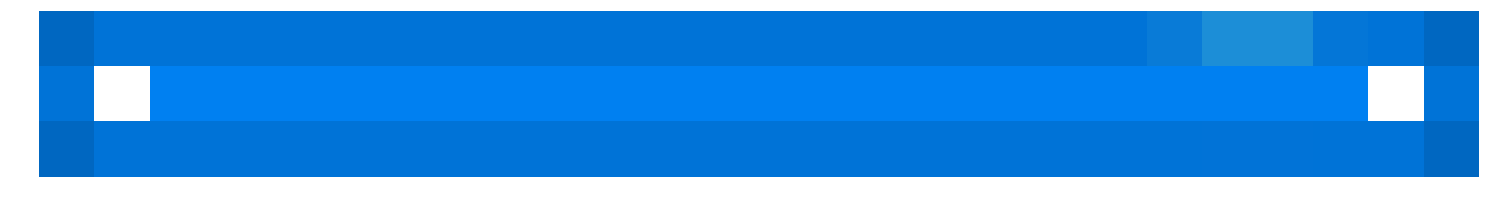

In [4]:
def detect_center(img): # координаты центра меняются по y
    img_copy = img.copy()
    center_img = img_copy[img.shape[0] // 2 - 5:img.shape[0] // 2 + 20, img.shape[1] // 2:img.shape[1] // 2 + 20]
    for i in range(center_img.shape[0]):
        for j in range(center_img.shape[1]):
            if np.any(center_img[i][j] != [180, 119, 31]):
                center_img[i][j] = [0, 0, 0]
    y = img.shape[0] // 2 - 5 + (max(center_img.nonzero()[0]) + min(center_img.nonzero()[0])) // 2
    x = img.shape[1] // 2 + (max(center_img.nonzero()[1]) + min(center_img.nonzero()[1])) // 2
    return y, x

# найдем координаты отрезка и значения коэффициентов для нормализации
img = cv2.imread("plots/20/6.png")
center = detect_center(img)
img = 255 - img
plt.figure(figsize=(20, 30))
print(center)
y_norm = img.shape[0]-center[0]-69 # столько пикселей в отрезке длины 1 по y
x_norm = 24 # 24 пикселя в отрезке длины 1 по x
y = img.shape[0]-70
x = 328 # начало координат
img[y][x] = [255,255,255]
img[y][x+23] = [255,255,255]
show(img[-71:-68,327:-287])

In [5]:
import numpy as np
from scipy.optimize import curve_fit

def norm_coordinates(xs, ys, center, plot):
    y_norm = plot.shape[0] - center[0] - 69
    ys_norm = (center[0] - ys) / y_norm
    xs_norm = (xs - center[1]) / 24
    return ys_norm, xs_norm

def get_params_for_parabola(plot, center):
    ys, xs = plot.nonzero()
    ys_norm, xs_norm = norm_coordinates(xs, ys, center, plot)
    func = lambda x, c, d, e: c * x * x + d * x + e
    params = curve_fit(func, xs_norm, ys_norm)[0]
    return params

def get_params_for_line(plot, center):
    ys, xs = plot.nonzero()
    ys_norm, xs_norm = norm_coordinates(xs, ys, center, plot)
    func = lambda x, f, g: f * x + g
    params = curve_fit(func, xs_norm, ys_norm)[0]
    return params

def get_params_for_sin(plot, center):
    ys, xs = plot.nonzero()
    func = lambda x, a, b: np.sin(a * x + b)

    points = sorted(list(zip(ys, xs)), key=lambda x: x[1])
    points_without_duplicates = [points[0]]
    for point in points:
        if point[1] != points_without_duplicates[-1][1]:
            points_without_duplicates.append(point)
    ys_rare, xs_rare = zip(*points_without_duplicates)
    ys_rare_norm, xs_rare_norm = norm_coordinates(xs_rare, ys_rare, center, plot)

    fourier = np.fft.rfft(ys_rare_norm)
    i = np.argmax(abs(fourier))
    step = (xs_rare_norm[1] - xs_rare_norm[0]) / (2 * np.pi)
    guess_f = np.fft.rfftfreq(len(xs_rare_norm), step)[i]

    params = curve_fit(func, xs_rare_norm, ys_rare_norm, p0=[guess_f, 1])[0]
    return params

def get_params(plots, center):
    i = np.argmax([len(plot.nonzero()[0]) for plot in plots])
    a, b = get_params_for_sin(plots[i], center)
    plots.pop(i)
    j = np.argmin([max(plot.nonzero()[0]) - min(plot.nonzero()[0]) for plot in plots])
    c, d, e = get_params_for_parabola(plots[j], center)
    plots.pop(j)
    f, g = get_params_for_line(plots[0], center)
    return a, b, c, d, e, f, g

In [6]:
my_dir = "plots/20/"
with open('my_par.txt', 'a') as file:
    print('pic,a,b,c,d,e,f,g', file=file)
for i in range(13):
    img = cv2.imread(my_dir + str(i) + '.png')
    center = detect_center(img)
    plots = separate_plots(img)
    a, b, c, d, e, f, g = get_params(plots, center)
    with open('my_par.txt', 'a') as file:
        print(i, a, b, c, d, e, f, g, sep=',', file=file)